In [72]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import time
import matplotlib.pyplot as plt

In [73]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU is available and will be used: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU not found. The model will run on the CPU.")

GPU is available and will be used: NVIDIA GeForce RTX 4060


In [74]:
df = pd.read_csv('../Weather_Merged_CSVs/Banana.csv')
df.head()

,District Name,Market Name,Commodity,Variety,Grade,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal),Price Date,Day Of Week,lookback_temp_mean,lookback_precip_sum
0,Dharmapuri,AJattihalli(Farmers Market),Banana,Besrai,Local,4000.0,4500.0,4500.0,2025-06-18,2,27.779167,258.2
1,Dharmapuri,AJattihalli(Farmers Market),Banana,Besrai,Local,4000.0,4500.0,4500.0,2024-12-26,3,25.363333,578.0
2,Dharmapuri,AJattihalli(Farmers Market),Banana,Besrai,Local,4500.0,5000.0,5000.0,2025-06-01,6,27.277500,217.9
3,Dharmapuri,AJattihalli(Farmers Market),Banana,Besrai,Local,4500.0,5000.0,5000.0,2025-06-17,1,27.753333,256.6
4,Dharmapuri,AJattihalli(Farmers Market),Banana,Besrai,Local,4500.0,5000.0,5000.0,2024-11-18,0,26.224167,542.6


In [75]:
# Time Series Analysis 
df['Price Date'] = pd.to_datetime(df['Price Date'])
df.sort_values('Price Date', inplace=True)
df.set_index('Price Date', inplace=True)

# Feature Engineering
df['day_of_year'] = df.index.dayofyear
df['week_of_year'] = df.index.isocalendar().week.astype(int)
df['month'] = df.index.month


df.head()

,District Name,Market Name,Commodity,Variety,Grade,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal),Day Of Week,lookback_temp_mean,lookback_precip_sum,day_of_year,week_of_year,month
Price Date,,,,,,,,,,,,,,
2016-04-30,Coimbatore,Sulur,Banana,Other,Large,1200.0,1400.0,1300.0,5,27.207500,12.8,121,17,4
2018-05-07,Coimbatore,Sulur,Banana,Other,Large,3200.0,3400.0,3300.0,0,27.240833,117.6,127,19,5
2018-09-20,Theni,Chinnamanur,Banana,Poovan,Medium,1300.0,1600.0,1450.0,3,26.824167,309.3,263,38,9
2018-09-27,Theni,Chinnamanur,Banana,Poovan,Medium,1300.0,1600.0,1450.0,3,26.780833,359.3,270,39,9
2018-10-12,Theni,Chinnamanur,Banana,Other,Medium,1200.0,1400.0,1300.0,4,26.440833,505.7,285,41,10


In [76]:
categorical_cols = ['District Name', 'Market Name', 'Commodity', 'Variety', 'Grade']
for col in categorical_cols:
    encoder = LabelEncoder()
    # Fit the encoder to the column and transform the text to numbers (e.g., 'Coimbatore', 'Theni' -> 0, 1)
    df[col] = encoder.fit_transform(df[col])
df.head()

,District Name,Market Name,Commodity,Variety,Grade,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal),Day Of Week,lookback_temp_mean,lookback_precip_sum,day_of_year,week_of_year,month
Price Date,,,,,,,,,,,,,,
2016-04-30,2,191,0,1,0,1200.0,1400.0,1300.0,5,27.207500,12.8,121,17,4
2018-05-07,2,191,0,1,0,3200.0,3400.0,3300.0,0,27.240833,117.6,127,19,5
2018-09-20,24,32,0,2,2,1300.0,1600.0,1450.0,3,26.824167,309.3,263,38,9
2018-09-27,24,32,0,2,2,1300.0,1600.0,1450.0,3,26.780833,359.3,270,39,9
2018-10-12,24,32,0,1,2,1200.0,1400.0,1300.0,4,26.440833,505.7,285,41,10


In [77]:
# Scales values between 0 and 1 for each column
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled_data, columns=df.columns)
df_scaled.head()

,District Name,Market Name,Commodity,Variety,Grade,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal),Day Of Week,lookback_temp_mean,lookback_precip_sum,day_of_year,week_of_year,month
0,0.057143,0.795833,0.0,0.333333,0.000000,0.047428,0.013803,0.012803,0.833333,0.759520,0.000000,0.328767,0.313725,0.272727
1,0.057143,0.795833,0.0,0.333333,0.000000,0.127476,0.033807,0.032807,0.000000,0.761455,0.083049,0.345205,0.352941,0.363636
2,0.685714,0.133333,0.0,0.666667,0.666667,0.051431,0.015803,0.014303,0.500000,0.737262,0.234963,0.717808,0.725490,0.727273
3,0.685714,0.133333,0.0,0.666667,0.666667,0.051431,0.015803,0.014303,0.500000,0.734746,0.274586,0.736986,0.745098,0.727273
4,0.685714,0.133333,0.0,0.333333,0.666667,0.047428,0.013803,0.012803,0.666667,0.715005,0.390601,0.778082,0.784314,0.818182


In [78]:
def create_sequences(data, n_steps, target_column):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data.iloc[i:(i + n_steps)].values)
        y.append(data.iloc[i + n_steps][target_column])
    return np.array(X), np.array(y).reshape(-1, 1)

In [79]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

In [80]:
# Tuning n_steps
n_steps_to_test = [7, 14, 21, 30, 60]
RMSE_results = {}
target_column = 'Modal Price (Rs./Quintal)'

best_n_steps = -1
best_nrmse = float('inf')
best_predictions = None
best_actuals = None

for n_steps in n_steps_to_test:
    print("-" * 50)
    print(f"Testing with n_steps = {n_steps}")
    start_time = time.time()

    # 1. Create sequences for the current n_steps
    X, y = create_sequences(df_scaled, n_steps, target_column)

    # 2. Split data and create PyTorch Tensors
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).float()
    X_test_tensor = torch.from_numpy(X_test).float()
    y_test_tensor = torch.from_numpy(y_test).float()

    # 3. Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # 4. Initialize the Model, Loss, and Optimizer
    input_size = X_train.shape[2]
    model = GRUModel(input_size, hidden_size=50, num_layers=2, output_size=1, dropout_prob=0.2).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 5. Train the Model
    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # 6. Make Predictions
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for batch_X, _ in test_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            all_predictions.append(outputs.cpu().numpy())
    predictions = np.concatenate(all_predictions)

    # 7. Inverse Transform to Get Actual Price Values
    price_col_index = df_scaled.columns.get_loc(target_column)
    
    # Inverse predictions
    dummy_pred = np.zeros((len(predictions), df_scaled.shape[1]))
    dummy_pred[:, price_col_index] = predictions.flatten()
    inversed_predictions = scaler.inverse_transform(dummy_pred)[:, price_col_index]
    
    # Inverse actual values
    dummy_actual = np.zeros((len(y_test), df_scaled.shape[1]))
    dummy_actual[:, price_col_index] = y_test.flatten()
    inversed_actual = scaler.inverse_transform(dummy_actual)[:, price_col_index]
    
    # 8. Calculate and Store RMSE
    rmse = np.sqrt(mean_squared_error(inversed_actual, inversed_predictions))
    mean_actual_price = np.mean(inversed_actual)
    nrmse = rmse / mean_actual_price
    RMSE_results[n_steps] = {'rmse': rmse, 'nrmse': nrmse}

    if nrmse < best_nrmse:
        best_nrmse = nrmse
        best_n_steps = n_steps
        best_predictions = inversed_predictions
        best_actuals = inversed_actual

    end_time = time.time()
    print(f"n_steps = {n_steps} | RMSE = {rmse:.2f} | nRMSE (%) = {nrmse * 100:.2f}% | Time = {end_time - start_time:.2f}s")


--------------------------------------------------
Testing with n_steps = 7
n_steps = 7 | RMSE = 1629.61 | nRMSE (%) = 28.96          % | Time = 125.29s
--------------------------------------------------
Testing with n_steps = 14
n_steps = 14 | RMSE = 1584.13 | nRMSE (%) = 28.16          % | Time = 120.39s
--------------------------------------------------
Testing with n_steps = 21
n_steps = 21 | RMSE = 1620.45 | nRMSE (%) = 28.80          % | Time = 121.53s
--------------------------------------------------
Testing with n_steps = 30
n_steps = 30 | RMSE = 1608.81 | nRMSE (%) = 28.59          % | Time = 124.33s
--------------------------------------------------
Testing with n_steps = 60
n_steps = 60 | RMSE = 1584.61 | nRMSE (%) = 28.17          % | Time = 119.62s


In [81]:
print("\n" + "="*60)
print("Hyperparameter Tuning Results:")
print("="*60)
print(f"{'n_steps':<10} | {'RMSE (Rs./Quintal)':<20} | {'nRMSE (%)':<15}")
print("-" * 55)
for n_steps, metrics in RMSE_results.items():
    print(f"{n_steps:<10} | {metrics['rmse']:<20.2f} | {metrics['nrmse'] * 100:<15.2f}%")
print("-" * 55)
print(f"Best n_steps found: {best_n_steps} with an nRMSE of {best_nrmse * 100:.2f}%")
print("="*60)


Hyperparameter Tuning Results:
n_steps    | RMSE (Rs./Quintal)   | nRMSE (%)      
-------------------------------------------------------
7          | 1629.61              | 28.96          %
14         | 1584.13              | 28.16          %
21         | 1620.45              | 28.80          %
30         | 1608.81              | 28.59          %
60         | 1584.61              | 28.17          %
-------------------------------------------------------
Best n_steps found: 14 with an nRMSE of 28.16%



Generating plot for the best performing model...
Plot saved as best_model_prediction_plot.png


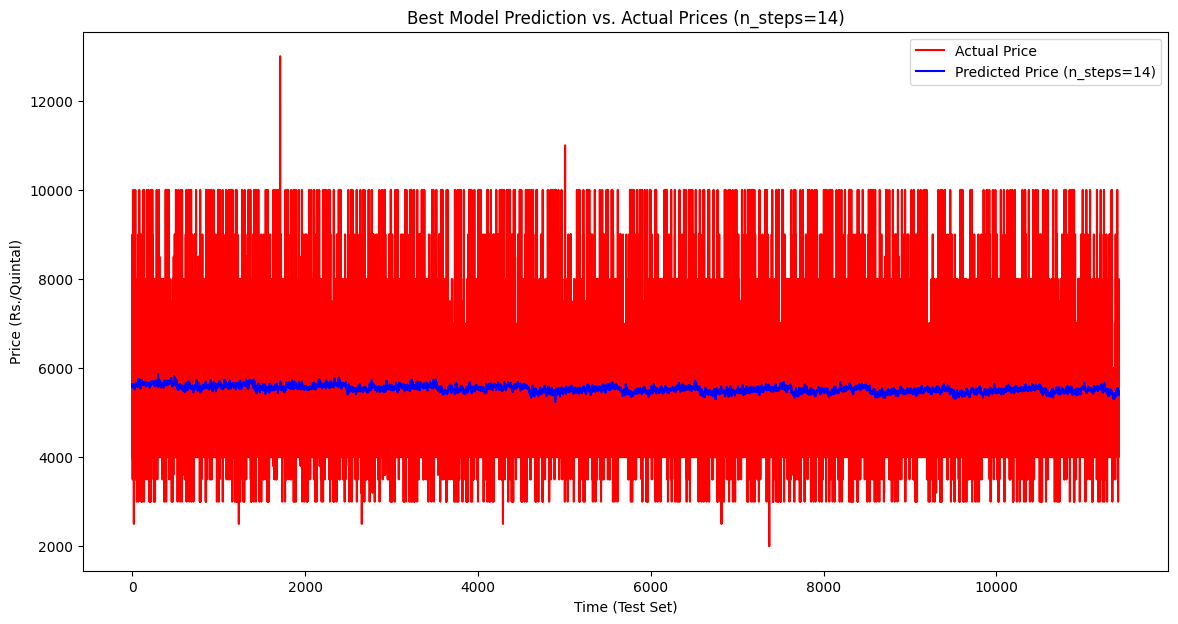

In [ ]:
if best_predictions is not None and best_actuals is not None:
    print("\nGenerating plot for the best performing GRU model...")
    plt.figure(figsize=(14, 7))
    plt.plot(best_actuals, color='red', label=f'Actual Price')
    plt.plot(best_predictions, color='blue', label=f'Predicted Price (n_steps={best_n_steps})')
    plt.title(f'Best Model Prediction vs. Actual Prices (n_steps={best_n_steps})')
    plt.xlabel('Time (Test Set)')
    plt.ylabel('Price (Rs./Quintal)')
    plt.legend()
else:
    print("No predictions were saved to plot.")